<a href="https://colab.research.google.com/github/GFDRR/caribbean-rooftop-classification/blob/add%2Ftutorials/tutorials/01_building_delineation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Footprint Delineation from Aerial Imagery

In this tutorial, you will learn how to automatically extract building footprints from aerial imagery using the Segment Anything Model (SAM).

## Install Dependencies

In [1]:
%%capture
!git clone https://github.com/GFDRR/caribbean-rooftop-classification.git
!pip -q install -U segment-geospatial
!pip -q install -U git+https://github.com/IDEA-Research/GroundingDINO.git
!pip -q install leafmap huggingface_hub

In [2]:
%cd caribbean-rooftop-classification/
!git checkout add/tutorials

/content/caribbean-rooftop-classification
Branch 'add/tutorials' set up to track remote branch 'add/tutorials' from 'origin'.
Switched to a new branch 'add/tutorials'
/content/caribbean-rooftop-classification/tutorials


## Imports and Setup

In [3]:
import os
import gdown

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
import leafmap

from rasterio.plot import show
from shapely.geometry import box
from samgeo import SamGeo

import sys
sys.path.insert(0, "./")
from utils import sam_utils

%load_ext autoreload
%autoreload 2

## File Locations & Directories

In [ ]:
# Create output directory
out_dir = './output/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# Create temporary directory for intermediate outputs
temp_dir = './output/temp/'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# The final building delineation output file
# Feel free to change the name accordingly
filename = "output.gpkg"
out_file = os.path.join(out_dir, filename)

# Create directory for the drone image
image_dir = "./data/rasters/drone/"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Name of the drone image
# Feel free to change this name accordingly
filename = "drone.tif"
image_file = os.path.join(image_dir, filename)

## Download Image

In [4]:
gid = "1SBqJuGfCmrL9YXbwdoK3uOkbPSE4uFGJ"
url = f"https://drive.google.com/uc?id={gid}"
gdown.download(url, image_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SBqJuGfCmrL9YXbwdoK3uOkbPSE4uFGJ
To: /content/caribbean-rooftop-classification/data/rasters/drone/drone.tif
100%|██████████| 36.3M/36.3M [00:00<00:00, 175MB/s]


## Load Image

In [5]:
image = rio.open(image_file)
tiles = sam_utils.generate_tiles(image_file, size=3000)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

  0%|          | 0/12487272 [00:00<?, ?it/s]

Data dimensions: (9, 1)


geometry
0  POLYGON ((-61.43417 15.44615, -61.43417 15.447...
1  POLYGON ((-61.43348 15.44615, -61.43348 15.447...
2  POLYGON ((-61.43280 15.44615, -61.43280 15.447...

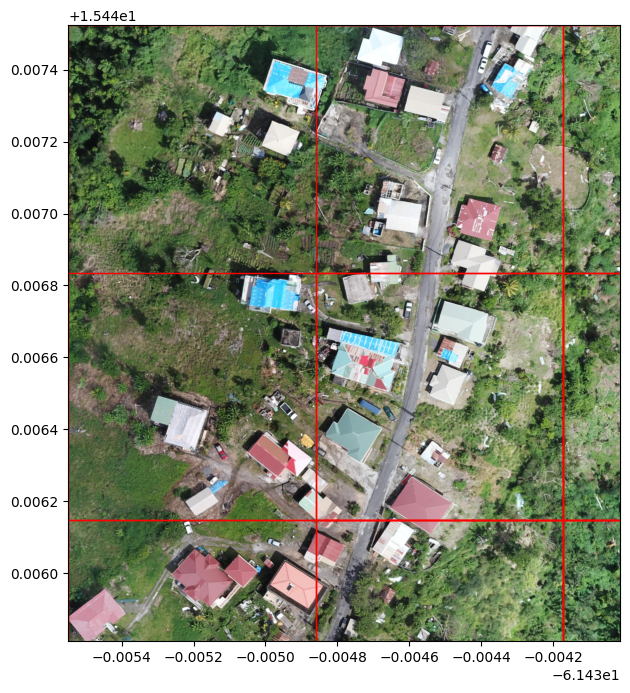

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
tiles.plot(facecolor="none", edgecolor='red', ax=ax, aspect=1)
show(image, ax=ax);

## LangSAM

In [7]:
text_prompt = "house"
model = sam_utils.LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:12<00:00, 212MB/s]


In [17]:
polygons = sam_utils.predict_image(
    image_file,
    text_prompt,
    tiles,
    model,
    out_dir,
    out_file,
    box_threshold=0.3,
    text_threshold=0.3,
);

  0%|          | 0/9 [00:00<?, ?it/s]

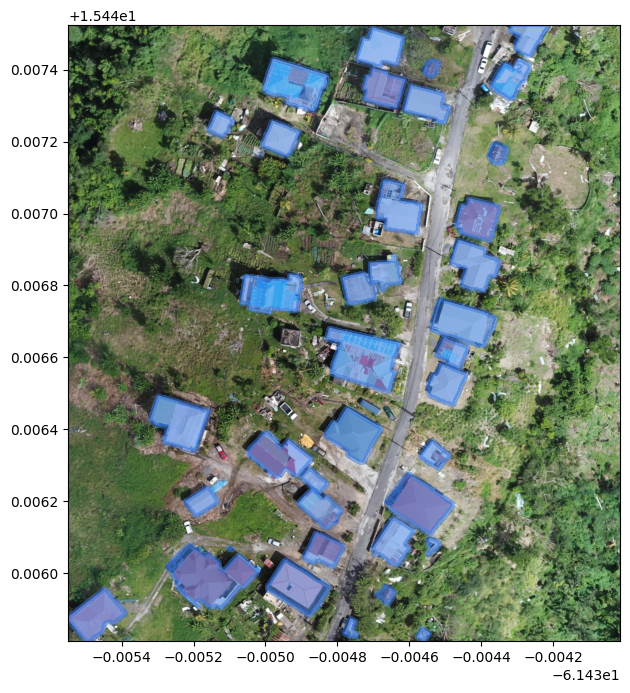

In [30]:
color = "#3476e0"
fig, ax = plt.subplots(figsize=(8,8))
polygons.plot(facecolor=color, edgecolor=color,  linewidth=3, alpha=0.5, ax=ax, aspect=1)
show(image, ax=ax);

## Interactive Plot

In [12]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install -q localtileserver

In [16]:
data = gpd.GeoDataFrame({"id":1,"geometry":[box(*image.bounds)]}, crs=image.crs).to_crs("EPSG:4326")
centroid = data.geometry.values[0].centroid

map = leafmap.Map(center=[centroid.y, centroid.x], zoom=20)
map.add_raster(image_file, layer_name="Image", zoom=20)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
map.add_vector(out_file, layer_name="Vector", style=style)
map

Map(center=[15.446667594304843, -61.43478104931424], controls=(ZoomControl(options=['position', 'zoom_in_text'…